In [2]:
# Test: Is everything working?
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import transformers
import datasets

print("✅ All libraries are working!")


✅ All libraries are working!


In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Salman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Salman\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [36]:
from datasets import load_dataset, concatenate_datasets
import pandas as pd

# Load all three splits of the dataset
dataset = load_dataset("go_emotions", "simplified")

# Combine train, validation, and test splits
full_dataset = concatenate_datasets([
    dataset["train"],
    dataset["validation"],
    dataset["test"]
])

# View a sample
print("✅ Sample data:")
print(full_dataset[0])

✅ Sample data:
{'text': "My favourite food is anything I didn't have to cook myself.", 'labels': [27], 'id': 'eebbqej'}


In [37]:
# Get list of emotion labels
label_names = dataset['train'].features['labels'].feature.names
print("\n📋 Emotion labels:")
for i, label in enumerate(label_names):
    print(f"{i}: {label}")


📋 Emotion labels:
0: admiration
1: amusement
2: anger
3: annoyance
4: approval
5: caring
6: confusion
7: curiosity
8: desire
9: disappointment
10: disapproval
11: disgust
12: embarrassment
13: excitement
14: fear
15: gratitude
16: grief
17: joy
18: love
19: nervousness
20: optimism
21: pride
22: realization
23: relief
24: remorse
25: sadness
26: surprise
27: neutral


In [38]:
# Convert HuggingFace dataset to pandas DataFrame
df = pd.DataFrame(full_dataset)

# Extract only the first label from the multi-label list
df['label'] = df['labels'].apply(lambda x: x[0])  # convert [7] → 7

# Keep only required columns
df = df[['text', 'label']]

# Map label number to emotion name
label_map = {i: label for i, label in enumerate(label_names)}
df['emotion'] = df['label'].map(label_map)

# Preview the DataFrame
print("\n✅ Total samples loaded:", len(df))
df.head()


✅ Total samples loaded: 54263


,text,label,emotion
0,My favourite food is anything I didn't have to...,27,neutral
1,"Now if he does off himself, everyone will thin...",27,neutral
2,WHY THE FUCK IS BAYLESS ISOING,2,anger
3,To make her feel threatened,14,fear
4,Dirty Southern Wankers,3,annoyance


 # 1. Preprocess the Text

In [39]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Function to clean and preprocess text
def clean_text(text):
    # Step 1: Convert all characters to lowercase
    # Example: "I Am Happy" -> "i am happy"
    text = text.lower()
    
    # Step 2: Remove all characters that are not alphabets or spaces
    # This removes punctuation, numbers, and special characters
    # Example: "I'm happy!!! 123" -> "im happy"
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Step 3: Split the cleaned text into words (tokens)
    # This splits on spaces and gives a list of words
    tokens = text.split()
    
    # Step 4: Remove common stopwords like "is", "the", "and", etc.
    # These words do not carry emotional weight
    filtered = [word for word in tokens if word not in stop_words]
    
    # Step 5: Join the filtered tokens back into a single string
    # Example: ['feeling', 'tired'] -> "feeling tired"
    return ' '.join(filtered)

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

df[['text', 'clean_text', 'emotion']].head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Salman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Salman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text,emotion
0,My favourite food is anything I didn't have to...,favourite food anything didnt cook,neutral
1,"Now if he does off himself, everyone will thin...",everyone think hes laugh screwing people inste...,neutral
2,WHY THE FUCK IS BAYLESS ISOING,fuck bayless isoing,anger
3,To make her feel threatened,make feel threatened,fear
4,Dirty Southern Wankers,dirty southern wankers,annoyance


# 2. Convert Text to Numbers (TF-IDF)

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text to numeric vectors
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])

# Target variable (emotion label)
y = df['emotion']

# 3. Train a Classification Model (Logistic Regression)

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# 4. Evaluate the Model

In [42]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.4967290150188888

Classification Report:
                 precision    recall  f1-score   support

    admiration       0.63      0.58      0.61      1066
     amusement       0.70      0.70      0.70       516
         anger       0.52      0.27      0.36       405
     annoyance       0.36      0.11      0.17       560
      approval       0.44      0.15      0.22       684
        caring       0.40      0.13      0.20       233
     confusion       0.39      0.11      0.17       283
     curiosity       0.51      0.10      0.17       423
        desire       0.66      0.28      0.40       144
disappointment       0.31      0.06      0.10       260
   disapproval       0.28      0.05      0.09       432
       disgust       0.60      0.31      0.41       152
 embarrassment       0.44      0.06      0.11        63
    excitement       0.44      0.19      0.26       155
          fear       0.77      0.37      0.50       138
     gratitude       0.79      0.81      0.80    

C:\Users\Salman\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Salman\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Salman\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

# Mood Trend Tracker – Step-by-Step Plan

#  Step 1: Simulate Journal Entries

In [43]:
from datetime import datetime, timedelta

# Example fake daily journal entries (feel free to modify or add your own)
entries = [
    "I feel so grateful for my family and friends.",
    "I'm feeling very sad and lonely today.",
    "What an amazing day! I loved everything about it.",
    "I’m extremely annoyed at how my project turned out.",
    "Feeling very tired and low. Nothing makes sense.",
    "Super excited to start this new journey!",
    "I'm really scared about my upcoming results.",
    "Not sure what I feel today, kind of blank.",
    "It was a boring and stressful day.",
    "I had a good laugh with my team. Felt nice!",
    "Missed an opportunity today. Feeling regretful.",
    "I’m curious about this new project at work.",
    "Someone said something that made me feel appreciated.",
    "Honestly, I’m just okay today. Nothing special.",
    "Felt disgusted by some rude behavior in class."
]

# Generate dates for the last N days
start_date = datetime.today() - timedelta(days=len(entries) - 1)
dates = [start_date + timedelta(days=i) for i in range(len(entries))]

#  Step 2: Predict Emotions

In [44]:
# Clean and vectorize entries
cleaned_entries = [clean_text(entry) for entry in entries]
X_entries = vectorizer.transform(cleaned_entries)
predicted_emotions = model.predict(X_entries)

# Step 3: Create Mood DataFrame

In [45]:
# Build DataFrame
mood_df = pd.DataFrame({
    "Date": [d.date() for d in dates],
    "Journal Entry": entries,
    "Predicted Emotion": predicted_emotions
})

print("\n📝 Mood Tracker Data:")
print(mood_df)


📝 Mood Tracker Data:
          Date                                      Journal Entry  \
0   2025-06-11      I feel so grateful for my family and friends.   
1   2025-06-12             I'm feeling very sad and lonely today.   
2   2025-06-13  What an amazing day! I loved everything about it.   
3   2025-06-14  I’m extremely annoyed at how my project turned...   
4   2025-06-15   Feeling very tired and low. Nothing makes sense.   
5   2025-06-16           Super excited to start this new journey!   
6   2025-06-17       I'm really scared about my upcoming results.   
7   2025-06-18         Not sure what I feel today, kind of blank.   
8   2025-06-19                 It was a boring and stressful day.   
9   2025-06-20        I had a good laugh with my team. Felt nice!   
10  2025-06-21    Missed an opportunity today. Feeling regretful.   
11  2025-06-22        I’m curious about this new project at work.   
12  2025-06-23  Someone said something that made me feel appre...   
13  2025-06-

# Step 4: Plot Mood Trend 📈

C:\Users\Salman\AppData\Local\Temp\ipykernel_21376\3037023946.py:11: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Salman\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


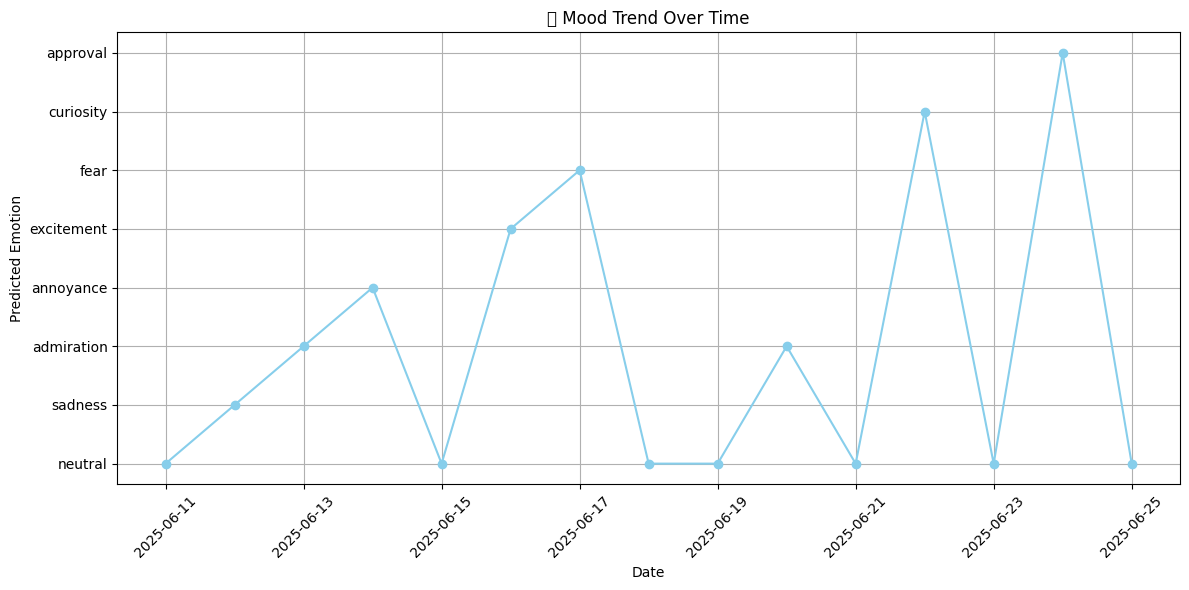

In [46]:
import matplotlib.pyplot as plt

# Count emotions per day (if same emotions appear repeatedly, group them)
plt.figure(figsize=(12, 6))
plt.plot(mood_df["Date"], mood_df["Predicted Emotion"], marker='o', linestyle='-', color='skyblue')
plt.xticks(rotation=45)
plt.title("🧠 Mood Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Predicted Emotion")
plt.grid(True)
plt.tight_layout()
plt.show()

# Save Your Model

In [48]:
import joblib

joblib.dump(model, "../models/emotion_model.pkl")
joblib.dump(vectorizer, "../models/tfidf_vectorizer.pkl")

['../models/tfidf_vectorizer.pkl']